### **1.0) Bibliotecas Necessárias**

In [2]:
import pandas as pd
from pathlib import Path
import pickle 
from datetime import datetime
from datetime import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, Markdown   
from sklearn.ensemble import IsolationForest
from pywaffle import Waffle
import calplot
from scipy.stats.mstats import winsorize
from scipy import special
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.lof import LOF
from pyod.models.knn import KNN


```mermaid
graph TD;
    A-->B;
    A-->C;
    B-->D;
    C-->D;
```

#### **2.0) Definições Globais**

In [3]:
Arquivo = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv"



#### **3.0) Leitura dos Dados Originais**

In [4]:
DadosBase = pd.read_csv ( Arquivo ) 
DadosBase = DadosBase.dropna(how = 'any', axis = 0)
dfTemp = DadosBase.copy()

### **4.0) Usando o Algoritmo LOF**

#### **4.1) Calculando LOF com Contaminação de 0.01**

In [5]:
dfTemp = DadosBase.copy()
dfCompĺeto = DadosBase.copy()
dfTemp ["Registro"] = DadosBase.index
dfTemp = dfTemp.drop('timestamp', axis=1)
# dfTemp
# dfCompĺeto


In [6]:

X = dfTemp.to_numpy()
lof = LOF(n_neighbors=10, contamination=0.01, metric='manhattan' )
lof.fit(X)



LOF(algorithm='auto', contamination=0.01, leaf_size=30, metric='manhattan',
  metric_params=None, n_jobs=1, n_neighbors=10, novelty=True, p=2)

In [7]:
probs = lof.predict_proba(X)
dfCompĺeto ["Probabilidade" ] = probs[:, 1]
dfCompĺeto ["Probabilidade"] = dfCompĺeto["Probabilidade"].astype("float32")
dfCompĺeto ["value"] = dfCompĺeto["value"].astype("float32")
dfCompĺeto ["Probabilidade" ] = dfCompĺeto ["Probabilidade" ].round(2)
# dfCompĺeto


In [8]:
dfExtrato = pd.DataFrame()
dfExtrato["Probabilidade"] = 0.0
dfExtrato["Total"] = 0

dfExtrato ["Probabilidade"] = dfExtrato["Probabilidade"].astype("float32")
dfExtrato ["Total"] = dfExtrato["Total"].astype("int32")


In [9]:
Resultados =    {
                    "Probabilidade": [],
                    "Total" : []
                }   

jIndice = 0
jAux = 0.1
while (jAux <= 1.0):
      filtro = dfCompĺeto['Probabilidade'] == jAux
      Resultados ["Total"].append ( dfCompĺeto[filtro]["value"].count() )
      Resultados ["Probabilidade"].append (jAux)

      jAux += 0.01
      jAux = round (jAux, 2)
      jIndice += 1

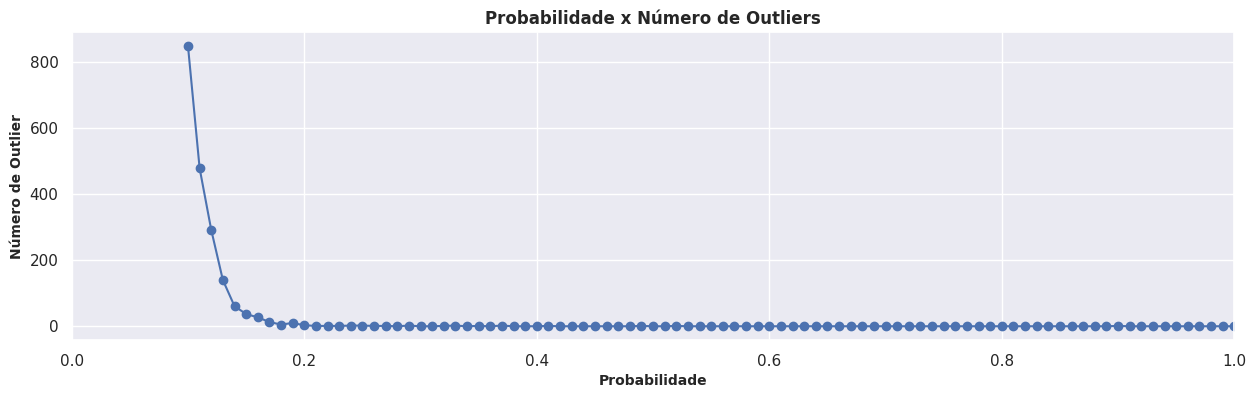

In [10]:
dfExtrato = pd.DataFrame(Resultados, columns=['Probabilidade', 'Total'])
plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")

plt.xlim (0, 1)
plt.plot( dfExtrato["Probabilidade"],  dfExtrato["Total"], marker = 'o')
plt.title("Probabilidade x Número de Outliers", fontsize=12, fontweight="bold" )
plt.ylabel('Número de Outlier', fontweight="bold", fontsize=10)
plt.xlabel ('Probabilidade', fontweight="bold", fontsize=10)
plt.show ()

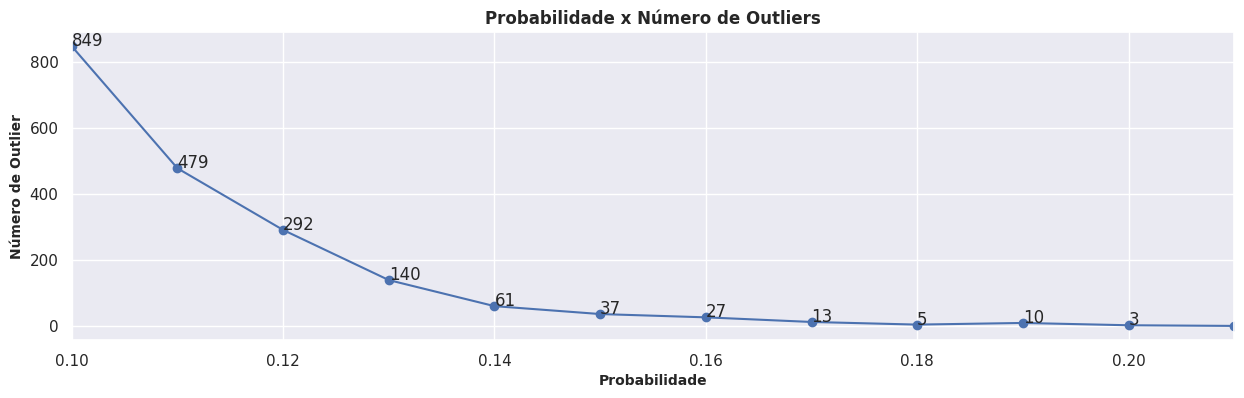

In [11]:
plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")

plt.xlim (0.1, 0.21)
plt.plot( dfExtrato["Probabilidade"],  dfExtrato["Total"], marker = 'o')
for iAux in enumerate ([0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20]):
    plt.text( iAux[1],  dfExtrato[dfExtrato["Probabilidade"] == iAux[1]]["Total"].values[0], '{:.0f}'.format(dfExtrato[dfExtrato["Probabilidade"] == iAux[1]]["Total"].values[0]))

plt.title("Probabilidade x Número de Outliers", fontsize=12, fontweight="bold" )
plt.ylabel('Número de Outlier', fontweight="bold", fontsize=10)
plt.xlabel ('Probabilidade', fontweight="bold", fontsize=10)
plt.show ()


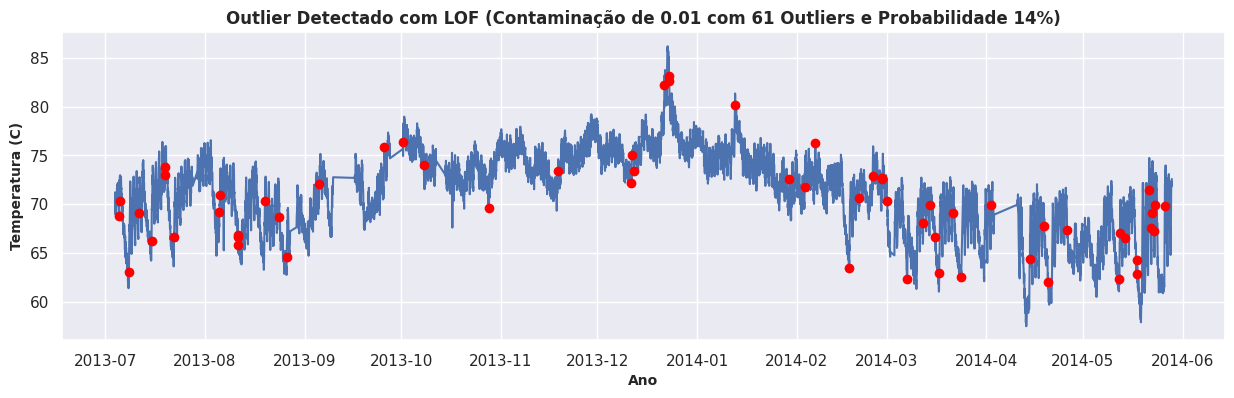

In [12]:
plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")

dfCompĺeto ["timestamp"] = pd.to_datetime(dfCompĺeto ["timestamp"]) 
plt.plot(dfCompĺeto['timestamp'] , dfCompĺeto['value'])
plt.plot (dfCompĺeto[dfCompĺeto["Probabilidade"]==0.14]["timestamp"], dfCompĺeto[dfCompĺeto["Probabilidade"]==0.14]["value"], 'o', color = 'red' )
plt.title("Outlier Detectado com LOF (Contaminação de 0.01 com 61 Outliers e Probabilidade 14%)", fontsize=12, fontweight="bold" )
plt.ylabel('Temperatura (C)', fontweight="bold", fontsize=10)
plt.xlabel ('Ano', fontweight="bold", fontsize=10)
plt.show ()

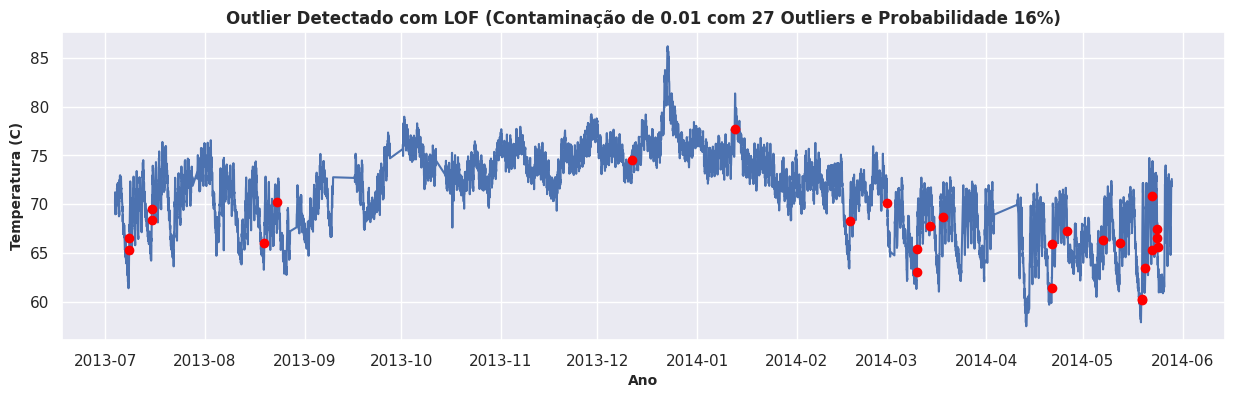

In [13]:
plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")

dfCompĺeto ["timestamp"] = pd.to_datetime(dfCompĺeto ["timestamp"]) 
plt.plot(dfCompĺeto['timestamp'] , dfCompĺeto['value'])
plt.plot (dfCompĺeto[dfCompĺeto["Probabilidade"]==0.16]["timestamp"], dfCompĺeto[dfCompĺeto["Probabilidade"]==0.16]["value"], 'o', color = 'red' )
plt.title("Outlier Detectado com LOF (Contaminação de 0.01 com 27 Outliers e Probabilidade 16%)", fontsize=12, fontweight="bold" )
plt.ylabel('Temperatura (C)', fontweight="bold", fontsize=10)
plt.xlabel ('Ano', fontweight="bold", fontsize=10)
plt.show ()

### **5.0) Usando o Algoritmo KNN**

In [14]:
dfTemp = DadosBase.copy()
dfCompĺeto = DadosBase.copy()
dfTemp ["Registro"] = DadosBase.index
dfTemp = dfTemp.drop('timestamp', axis=1)
# dfTemp
# dfCompĺeto

In [16]:
X = dfTemp.to_numpy()
knn = KNN (
            algorithm='auto',
            leaf_size=30,
            method='largest',
            metric='minkowski',
            metric_params=None,
            p=2,
            radius=1.0,
            n_neighbors=24, 
            contamination=0.05, 
            n_jobs=-1
          )
knn.fit(X)


KNN(algorithm='auto', contamination=0.05, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=24, p=2,
  radius=1.0)

In [53]:
probs = knn.predict_proba(X)
dfCompĺeto ["Probabilidade" ] = probs[:, 1]
dfCompĺeto ["Probabilidade"] = dfCompĺeto["Probabilidade"].astype("float32")
dfCompĺeto ["value"] = dfCompĺeto["value"].astype("float32")
dfCompĺeto ["Probabilidade" ] = dfCompĺeto ["Probabilidade" ].round(2)
# dfCompĺeto

In [54]:
dfExtrato = pd.DataFrame()
dfExtrato["Probabilidade"] = 0.0
dfExtrato["Total"] = 0

dfExtrato ["Probabilidade"] = dfExtrato["Probabilidade"].astype("float32")
dfExtrato ["Total"] = dfExtrato["Total"].astype("int32")


In [55]:

Resultados =    {
                    "Probabilidade": [],
                    "Total" : []
                }   

jIndice = 0
jAux = 0.1
while (jAux <= 1.0):
      filtro = dfCompĺeto['Probabilidade'] == jAux
      Resultados ["Total"].append ( dfCompĺeto[filtro]["value"].count() )
      Resultados ["Probabilidade"].append (jAux)

      jAux += 0.01
      jAux = round (jAux, 2)
      jIndice += 1

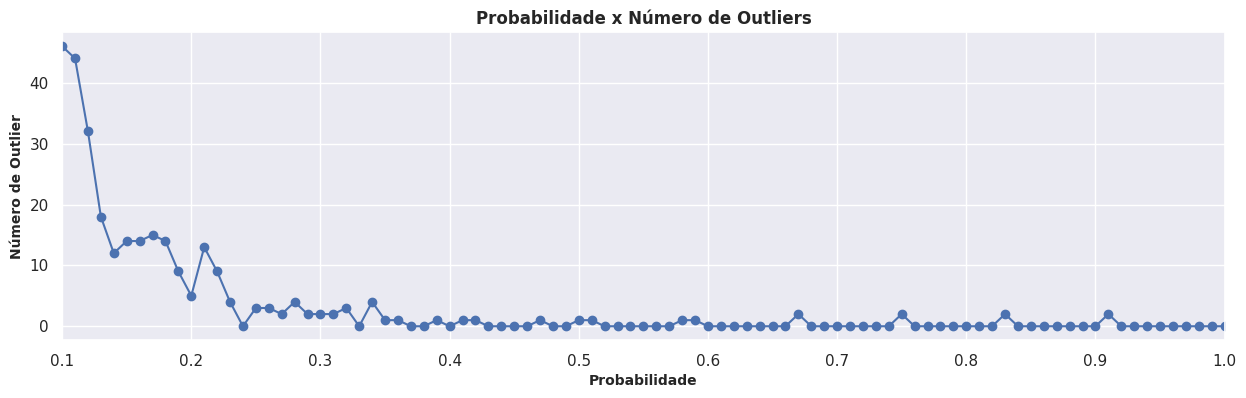

In [56]:
dfExtrato = pd.DataFrame(Resultados, columns=['Probabilidade', 'Total'])
plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")

plt.xlim (0.1, 1)
plt.plot( dfExtrato["Probabilidade"],  dfExtrato["Total"], marker = 'o')
plt.title("Probabilidade x Número de Outliers", fontsize=12, fontweight="bold" )
plt.ylabel('Número de Outlier', fontweight="bold", fontsize=10)
plt.xlabel ('Probabilidade', fontweight="bold", fontsize=10)
plt.show ()

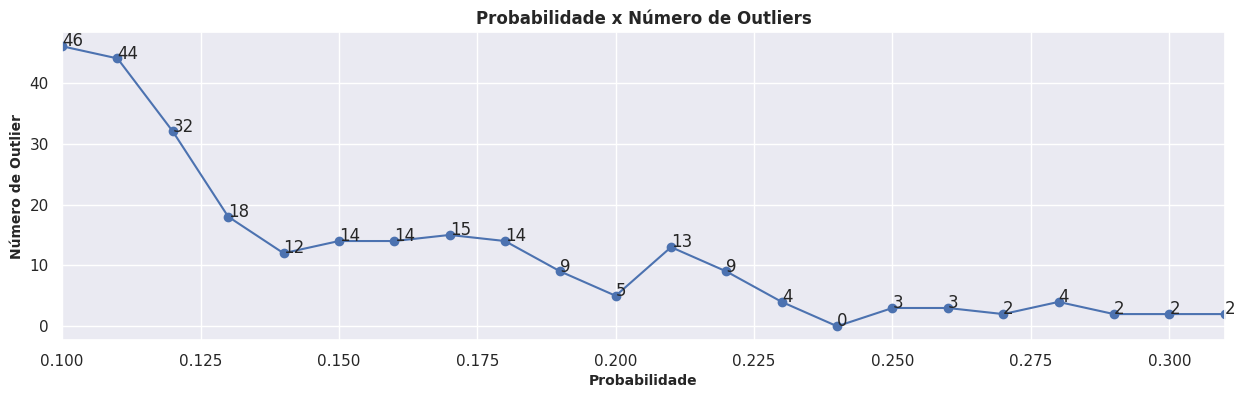

In [57]:
plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")

plt.xlim (0.1, 0.31)
plt.plot( dfExtrato["Probabilidade"],  dfExtrato["Total"], marker = 'o')
for iAux in enumerate ([0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31]):
    plt.text( iAux[1],  dfExtrato[dfExtrato["Probabilidade"] == iAux[1]]["Total"].values[0], '{:.0f}'.format(dfExtrato[dfExtrato["Probabilidade"] == iAux[1]]["Total"].values[0]))

plt.title("Probabilidade x Número de Outliers", fontsize=12, fontweight="bold" )
plt.ylabel('Número de Outlier', fontweight="bold", fontsize=10)
plt.xlabel ('Probabilidade', fontweight="bold", fontsize=10)
plt.show ()

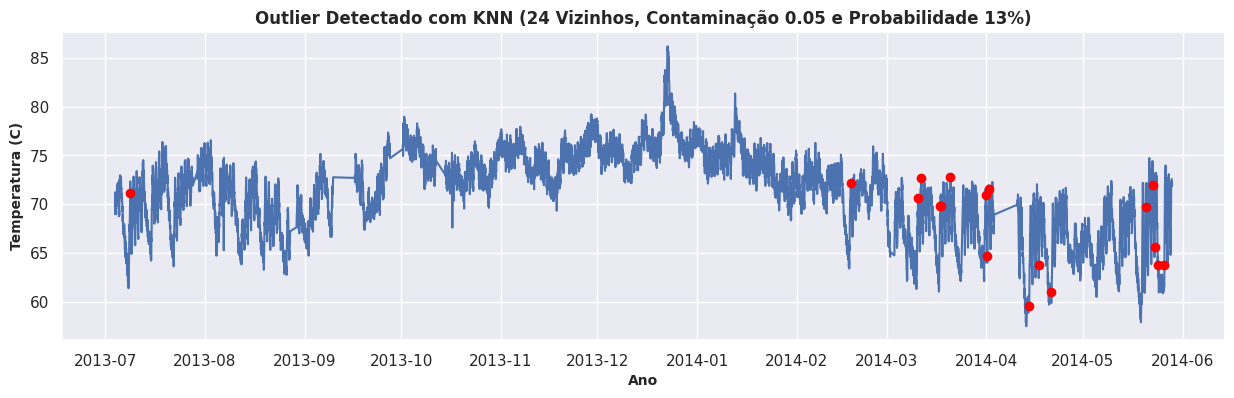

In [58]:
plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")

dfCompĺeto ["timestamp"] = pd.to_datetime(dfCompĺeto ["timestamp"]) 
plt.plot(dfCompĺeto['timestamp'] , dfCompĺeto['value'])
plt.plot (dfCompĺeto[dfCompĺeto["Probabilidade"]==0.13]["timestamp"], dfCompĺeto[dfCompĺeto["Probabilidade"]==0.13]["value"], 'o', color = 'red' )
plt.title("Outlier Detectado com KNN (24 Vizinhos, Contaminação 0.05 e Probabilidade 13%)", fontsize=12, fontweight="bold" )
plt.ylabel('Temperatura (C)', fontweight="bold", fontsize=10)
plt.xlabel ('Ano', fontweight="bold", fontsize=10)
plt.show ()